In [2]:
import os
from os.path import join as pjoin
import numpy as np
import matplotlib.pyplot as plt
from wfield import *
from sklearn.preprocessing import normalize
from scripts.jadeR import *
#from scripts.jadeR3 import *
from scripts.correlation import *

### Set and check your current working directory

In [ ]:
ica_folder = "ica_dir"

In [ ]:
fs = 20 # per channel
time = 34
ncomponents_ica = 10  # number of ics
ndisplay = 10

## Assumption

### - You have already corrected hemodynamics and got single channel data

### - U.npy is spatial components and SVTcorr.npy is hemo-corrected single channel trace

In [ ]:
## load svd results
U = np.load(pjoin(ica_folder, "u.npy"))
H, W, ncomponents_svd = U.shape
SVTcorr = np.load(pjoin(ica_folder, 'svt.npy'))
print(f"U.shape:{U.shape}")
print(f"SVTcorr.shape:{SVTcorr.shape}")

U.shape:(256, 270, 400)
SVTcorr.shape:(120, 400, 200)


In [80]:
SVTcorr = SVTcorr.transpose(1, 0, 2).reshape(SVTcorr.shape[1], SVTcorr.shape[0]*SVTcorr.shape[2])
print(SVTcorr.shape)

(400, 24000)


In [81]:
use_comps = 200
U = U[:,:,:use_comps]
H, W, ncomponents_svd = U.shape
SVTcorr = SVTcorr[:use_comps]

print(U.shape, SVTcorr.shape)

(256, 270, 200) (200, 24000)


## Most important in this notebook

In the cell below, **Independent Component analysis** is done by **_JADE algorithm_**

In [ ]:
jader_result = np.array(jadeR(X=SVTcorr, m=ncomponents_ica))
print(jader_result.shape)
np.save(pjoin(ica_folder, "jader.npy"), jader_result)
tc = np.matmul(jader_result, SVTcorr)
np.save(pjoin(ica_folder, "ic_temporal_components.npy"), tc)

(10, 200)


In [ ]:
jader_result = np.load(pjoin(ica_folder, "jader.npy"))
print(jader_result.shape)
tc = np.load(pjoin(ica_folder, "ic_temporal_components.npy"))
print(tc.shape)

(10, 200)
(10, 24000)


### From ICA result, make images of independent components

In [84]:
svd_result = U.transpose(2, 0, 1).reshape(ncomponents_svd, -1)
print(f"svd_result.shape\n(ncomponents_svd, H*W)={svd_result.shape}")

svd_result.shape
(ncomponents_svd, H*W)=(200, 69120)


In [85]:
independent_component_matrix = normalize(np.matmul(jader_result, svd_result))
print(f"\nindependent_component_matrix.shape\n(ncomponents_ica, H*W)={independent_component_matrix.shape}")


independent_component_matrix.shape
(ncomponents_ica, H*W)=(10, 69120)


In [86]:
independent_component_images = independent_component_matrix.reshape((ncomponents_ica, H, W))
print(f"independent_component_images.shape\n(ncomponents_ica, H, W)={independent_component_images.shape}")

independent_component_images.shape
(ncomponents_ica, H, W)=(10, 256, 270)


In [ ]:
tc = np.load(pjoin(ica_folder, "ic_temporal_components.npy"))
print(f"tc.shape:{tc.shape}")
time = [i/fs for i in range(len(tc[0,:]))]

tc.shape:(10, 24000)


In [89]:
print(independent_component_images.shape)
print(independent_component_matrix.shape)
print(tc.shape)

(10, 256, 270)
(10, 69120)
(10, 24000)


In [ ]:
use_ics = 10  # select ics by visual investigation
extracted_image = independent_component_images[:use_ics]
extracted_matrix = independent_component_matrix[:use_ics]
extracted_tc = tc[:use_ics]

print(extracted_image.shape)
print(extracted_matrix.shape)
print(extracted_tc.shape)

(10, 256, 270)
(10, 69120)
(10, 24000)


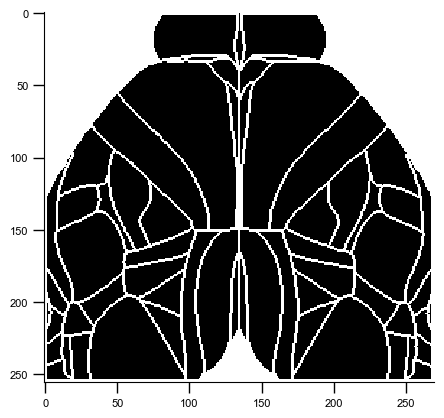

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

atlas_map = np.load("region_border_mask_path")
plt.imshow(atlas_map, cmap='grey')

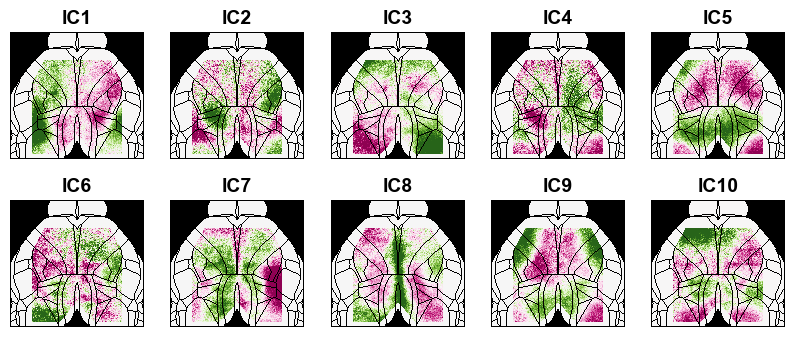

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))  
for ic in range(extracted_image.shape[0]):
    plt.subplot(2, 5, ic+1)

    mask = atlas_map
    masked = np.ma.masked_where(mask == 1, extracted_image[ic])
    cmap = plt.cm.PiYG.copy()
    cmap.set_bad(color='black') 
    plt.imshow(masked, cmap=cmap, vmin=-0.01, vmax=+0.01)
    plt.title(f"IC{ic+1}")
    plt.axis('off')

plt.show()

In [ ]:
ex_number = 119  # number of trials
extracted_tc = extracted_tc.reshape(extracted_tc.shape[0], ex_number, int(extracted_tc.shape[1]/ex_number))
print(extracted_tc.shape)

(10, 120, 200)


In [ ]:
np.save(pjoin(ica_folder, "ic_image_extracted.npy"), extracted_image)  # spatial components (2 dimentions) 
np.save(pjoin(ica_folder, "ic_matrix_extracted.npy"), extracted_matrix) # spatial components (1 dimentions) 
np.save(pjoin(ica_folder, "ic_temporal_components_extracted.npy"), extracted_tc)    